In [1]:
import simulations as sims
import numpy as np 
import matplotlib.pyplot as plt
from opt_einsum import contract 
from scipy.stats import spearmanr
import torch.nn as nn
import torch
from sklearn.decomposition import NMF
import itertools
import seaborn as sns
import pandas as pd
import netNMFsc
import scipy

#scHPF imports
from schpf import scHPF, run_trials, run_trials_pool
from schpf import load_model, save_model


#slalom imports
import slalom
from slalom import plotFactors, plotRelevance, saveFA, dumpFA

netNMFMU imported
netNMFGD imported


In [2]:
from spectra import spectra as spc

## Simulations

- Edge recovery 
- K estimation
- version of the correlated factors without NMF

In [3]:
spc.SPECTRA_Model

spectra.spectra.SPECTRA_Model

In [4]:
N = 60
k = 5
p = 50
rho = 0.8
sigma = 4.0
def simulate_corr_data(rho,N,k,p, sigma):
    """ 
    first two coordinates are correlated
    """
    theta_star = np.abs(np.random.standard_cauchy(size = (p,k)))
    #theta_star[theta_star < 2.0] = 0
    np.argsort(theta_star, axis = 1)
    cov = np.eye(k) 
    cov[0,1] = cov[0,1] + rho
    cov[1,0] = cov[1,0] + rho
    lst = []
    for i in range(N):
        a = np.exp(np.random.multivariate_normal(np.zeros(k),cov))
        lst.append(a)
    A_star = np.array(lst)
    global_mean = contract('ik,jk->ij',A_star,theta_star) 
    global_mean = global_mean + np.random.normal(loc= 0,scale = sigma, size = global_mean.shape)
    # adding random noise 
    global_mean[global_mean < 0] = 0
    data = np.random.poisson(global_mean) 
    return(data,A_star,theta_star)

#find best permutation
def best_permutation(true_theta, estimate):
    max_reward = -1.0*np.inf 
    k = true_theta.shape[1]
    for permutation in itertools.permutations(list(range(k))):
        reward = 0
        for i in range(k):
            if estimate.shape[1] == k:
                reward += spearmanr(estimate[:,permutation][:,i],true_theta[:,i]).correlation
            else:
                reward += spearmanr(estimate[permutation,:][i,:],true_theta[:,i]).correlation
        reward = reward/k
        if np.isnan(reward):
            reward = 0.0
        if reward > max_reward:
            best_perm = permutation
            max_reward = reward
    return best_perm, max_reward

In [5]:
def construct_A_matrix(theta_star,n_top):
    # get top markers for 0 and 1
    lst0 = np.argsort(theta_star[:,0])[::-1][:n_top]
    lst1 = np.argsort(theta_star[:,1])[::-1][:n_top]
    A = np.zeros((p,p))
    for i in lst0:
        for j in lst0:
            if i != j:
                A[i,j] = 1
    for i in lst1:
        for j in lst1:
            if i != j:
                A[i,j] = 1
    return(A) 

def construct_A_matrix_w(theta_star):
    # get top markers for 0 and 1
    theta = theta_star/theta_star.sum(axis = 1, keepdims =True)
    theta[~np.isfinite(theta)] = 0.0
    EA = contract('ik,jk->ij', theta, theta)
    A = np.random.binomial(1, EA - np.diag(np.diag(EA)))
    return(A) 

## Plots related to Supp. Fig S5A

In [6]:
def create_mask(input_lst, G_input, D):
    input_mask = np.zeros((G_input, D))
    for i in range(len(input_lst)):
        for input_ in input_lst[i]:
            input_mask[i,input_]  = 1.0 
    return input_mask

In [1]:
N = 20
k = 3
p = 500
sigma = 2.0
lam = 0.1
n_top = 20
rhos = []
models = []
corr_group = []
results = []
model_kwargs = dict(a=0.3, c=0.3)

for rho in [0.25,0.5,0.7, 0.85,0.9,0.95,0.99]:
    for trial in range(10):
        np.random.seed(trial)
        data, A_star,theta_star = simulate_corr_data(rho,N,k,p,sigma)
        A = construct_A_matrix_w(theta_star)
        nmf = NMF(n_components=k)
        Y_nmf = nmf.fit_transform(data)
        nmf_theta = nmf.components_/nmf.components_.sum(axis = 0, keepdims =True)
        theta = theta_star/theta_star.sum(axis = 1, keepdims =True)
        
        lst = []
        for i in range(k):
            lst.append(list(theta.argsort(axis = 0)[-1*n_top:,:][:,i]))
        

        model = spc.SPECTRA_Model(X = data, labels = None, L = k, adj_matrix = A, use_weights = False, lam = lam, delta=0.0,use_cell_types = False, kappa = 0.0, rho = 0.0)
        #initialize eta
        model.internal_model.theta = nn.Parameter(torch.log(torch.Tensor(nmf_theta.T) + 0.000001))
        model.internal_model.eta = nn.Parameter(torch.eye(k)*10)
        model.train(X = data)
        spectra_theta = torch.softmax(model.internal_model.theta, dim = 1).detach().numpy().T
        #spectra_theta = theta*(model.internal_model.gene_scaling.exp().detach()/(1.0 + model.internal_model.gene_scaling.exp().detach()) + model.internal_model.delta).numpy().reshape(1,-1)
        
        theta = theta_star/theta_star.sum(axis = 1, keepdims =True)
        
        
        model = run_trials(scipy.sparse.coo_matrix(data), vcells=None, nfactors=k, 
                        ntrials=1, min_iter=20,
                        max_iter=1000, check_freq=10,
                        epsilon=0.001,
                        better_than_n_ago=5, dtype=np.float32,
                        verbose=True, model_kwargs=model_kwargs,
                        return_all=False, reproject=True,
                        batchsize=0,
                        beta_theta_simultaneous=True,
                        loss_smoothing=1
                        )
        schpf_theta = model.beta.e_x.T / (model.beta.e_x.T.sum(axis = 0, keepdims = True))
        
        I = create_mask(np.array(lst), G_input = k, D= p).T.astype(int)
        terms = np.array(range(k)).astype(str)
        FA = slalom.initFA(Y = data.astype(float), terms = terms, I = I, noise='gauss', 
            nHidden=0, nHiddenSparse=0,do_preTrain=False, minGenes = 1, pruneGenes = False)
        FA.train()
        temp = (FA.getW()*FA.getZ()).T
        slalom_theta = temp/temp.sum(axis = 0, keepdims = True)
        
        best_schpf = best_permutation(theta,schpf_theta)
        best_nmf = best_permutation(theta,nmf_theta)
        best_spade = best_permutation(theta,spectra_theta)
        best_slalom = best_permutation(theta, slalom_theta)
        
        nfactors = [np.corrcoef(nmf_theta[best_nmf[0],:][i,:], theta[:,i])[0,1] for i in range(k)]
        sfactors = [np.corrcoef(spectra_theta[best_spade[0],:][i,:], theta[:,i])[0,1] for i in range(k)]
        hfactors = [np.corrcoef(schpf_theta[best_schpf[0],:][i,:], theta[:,i])[0,1] for i in range(k)]
        slfactors = [np.corrcoef(slalom_theta[best_slalom[0],:][i,:], theta[:,i])[0,1] for i in range(k)]
        
        #collect results
        results.append(np.mean(nfactors[2:]))
        rhos.append(rho)
        models.append("NMF")
        corr_group.append("U")
        
        #collect results
        results.append(np.mean(nfactors[0:2]))
        rhos.append(rho)
        models.append("NMF")
        corr_group.append("C")
        
        #collect results
        results.append(np.mean(sfactors[2:]))
        rhos.append(rho)
        models.append("Spectra")
        corr_group.append("U")
        
        #collect results
        results.append(np.mean(sfactors[0:2]))
        rhos.append(rho)
        models.append("Spectra")
        corr_group.append("C")
        
        #collect results
        results.append(np.mean(hfactors[2:]))
        rhos.append(rho)
        models.append("scHPF")
        corr_group.append("U")
        
        #collect results
        results.append(np.mean(hfactors[0:2]))
        rhos.append(rho)
        models.append("scHPF")
        corr_group.append("C")
        
        #collect results
        results.append(np.mean(slfactors[2:]))
        rhos.append(rho)
        models.append("slalom")
        corr_group.append("U")
        
        #collect results
        results.append(np.mean(slfactors[0:2]))
        rhos.append(rho)
        models.append("slalom")
        corr_group.append("C")

In [8]:
results_df2 = pd.DataFrame()
results_df2["rho"] = rhos
results_df2["model"] = models
results_df2["corr"] = corr_group
results_df2["value"] = results

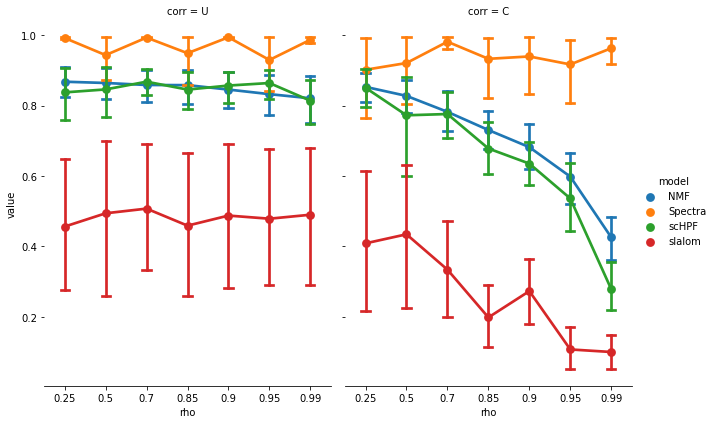

In [11]:
g = sns.catplot(x="rho", y="value", hue="model", col="corr",
                capsize=.2,  height=6, aspect=.75,
                kind="point", data=results_df2)
g.despine(left=True)
plt.savefig("simulation_correlated_factors.svg")

In [155]:
results_df2[(results_df2.rho == 0.25)&(results_df2.model == "NMF")]

,rho,model,corr,value
0,0.25,NMF,U,0.637732
1,0.25,NMF,C,0.646530
8,0.25,NMF,U,0.637732
9,0.25,NMF,C,0.646530
16,0.25,NMF,U,0.637732
17,0.25,NMF,C,0.646530
24,0.25,NMF,U,0.637732
25,0.25,NMF,C,0.646530
32,0.25,NMF,U,0.637732
33,0.25,NMF,C,0.646530


## Same code for scHPF

In [138]:
I = create_mask(np.array(lst), G_input = k, D= p).T.astype(int)
terms = np.array(range(k)).astype(str)
FA = slalom.initFA(Y = data.astype(float), terms = terms, I = I, noise='gauss', 
    nHidden=0, nHiddenSparse=0,do_preTrain=False, minGenes = 1, pruneGenes = False)

## Other settings

In [2]:
N = 100
k = 3
p = 500
sigma = 2.0
lam = 0.02
n_top = 20
rhos = []
models = []
corr_group = []
results = []
model_kwargs = dict(a=0.3, c=0.3)

for rho in [0.25,0.5,0.7, 0.85,0.9,0.95,0.99]:
    for trial in range(10):
        np.random.seed(trial)
        data, A_star,theta_star = simulate_corr_data(rho,N,k,p,sigma)
        A = construct_A_matrix_w(theta_star)
        nmf = NMF(n_components=k)
        Y_nmf = nmf.fit_transform(data)
        nmf_theta = nmf.components_/nmf.components_.sum(axis = 0, keepdims =True)
        theta = theta_star/theta_star.sum(axis = 1, keepdims =True)
        
        lst = []
        for i in range(k):
            lst.append(list(theta.argsort(axis = 0)[-1*n_top:,:][:,i]))
        

        model = spc.SPECTRA_Model(X = data, labels = None, L = k, adj_matrix = A, use_weights = False, lam = lam, delta=0.0,use_cell_types = False, kappa = 0.0, rho = 0.0)
        #initialize eta
        model.alpha = torch.log(torch.Tensor(Y_nmf) + 0.000000001)
        model.internal_model.theta = nn.Parameter(torch.log(torch.Tensor(nmf_theta.T) + 0.000001))
        model.internal_model.eta = nn.Parameter(torch.eye(k)*10)
        model.train(X = data)
        spectra_theta = torch.softmax(model.internal_model.theta, dim = 1).detach().numpy().T
        #spectra_theta = theta*(model.internal_model.gene_scaling.exp().detach()/(1.0 + model.internal_model.gene_scaling.exp().detach()) + model.internal_model.delta).numpy().reshape(1,-1)
        
        theta = theta_star/theta_star.sum(axis = 1, keepdims =True)
        
        
        model = run_trials(scipy.sparse.coo_matrix(data), vcells=None, nfactors=k, 
                        ntrials=1, min_iter=20,
                        max_iter=1000, check_freq=10,
                        epsilon=0.001,
                        better_than_n_ago=5, dtype=np.float32,
                        verbose=True, model_kwargs=model_kwargs,
                        return_all=False, reproject=True,
                        batchsize=0,
                        beta_theta_simultaneous=True,
                        loss_smoothing=1
                        )
        schpf_theta = model.beta.e_x.T / (model.beta.e_x.T.sum(axis = 0, keepdims = True))
        
        I = create_mask(np.array(lst), G_input = k, D= p).T.astype(int)
        terms = np.array(range(k)).astype(str)
        FA = slalom.initFA(Y = data.astype(float), terms = terms, I = I, noise='gauss', 
            nHidden=0, nHiddenSparse=0,do_preTrain=False, minGenes = 1, pruneGenes = False)
        FA.train()
        temp = (FA.getW()*FA.getZ()).T
        slalom_theta = temp/temp.sum(axis = 0, keepdims = True)
        
        best_schpf = best_permutation(theta,schpf_theta)
        best_nmf = best_permutation(theta,nmf_theta)
        best_spade = best_permutation(theta,spectra_theta)
        best_slalom = best_permutation(theta, slalom_theta)
        
        nfactors = [np.corrcoef(nmf_theta[best_nmf[0],:][i,:], theta[:,i])[0,1] for i in range(k)]
        sfactors = [np.corrcoef(spectra_theta[best_spade[0],:][i,:], theta[:,i])[0,1] for i in range(k)]
        hfactors = [np.corrcoef(schpf_theta[best_schpf[0],:][i,:], theta[:,i])[0,1] for i in range(k)]
        slfactors = [np.corrcoef(slalom_theta[best_slalom[0],:][i,:], theta[:,i])[0,1] for i in range(k)]
        
        #collect results
        results.append(np.mean(nfactors[2:]))
        rhos.append(rho)
        models.append("NMF")
        corr_group.append("U")
        
        #collect results
        results.append(np.mean(nfactors[0:2]))
        rhos.append(rho)
        models.append("NMF")
        corr_group.append("C")
        
        #collect results
        results.append(np.mean(sfactors[2:]))
        rhos.append(rho)
        models.append("Spectra")
        corr_group.append("U")
        
        #collect results
        results.append(np.mean(sfactors[0:2]))
        rhos.append(rho)
        models.append("Spectra")
        corr_group.append("C")
        
        #collect results
        results.append(np.mean(hfactors[2:]))
        rhos.append(rho)
        models.append("scHPF")
        corr_group.append("U")
        
        #collect results
        results.append(np.mean(hfactors[0:2]))
        rhos.append(rho)
        models.append("scHPF")
        corr_group.append("C")
        
        #collect results
        results.append(np.mean(slfactors[2:]))
        rhos.append(rho)
        models.append("slalom")
        corr_group.append("U")
        
        #collect results
        results.append(np.mean(slfactors[0:2]))
        rhos.append(rho)
        models.append("slalom")
        corr_group.append("C")

In [37]:
results_df2 = pd.DataFrame()
results_df2["rho"] = rhos
results_df2["model"] = models
results_df2["corr"] = corr_group
results_df2["value"] = results

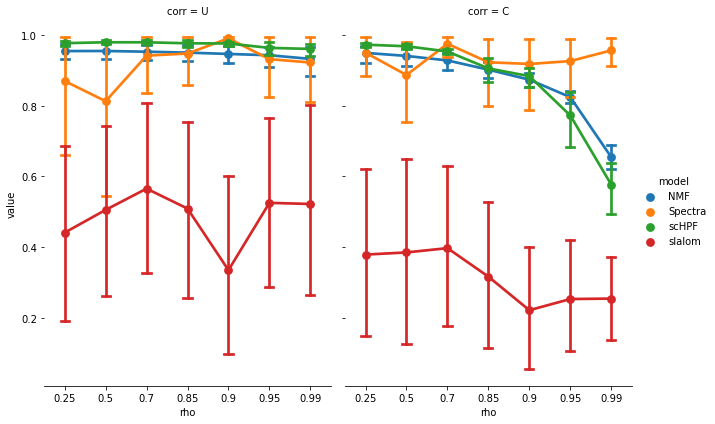

In [38]:
g = sns.catplot(x="rho", y="value", hue="model", col="corr",
                capsize=.2,  height=6, aspect=.75,
                kind="point", data=results_df2)
g.despine(left=True)
plt.savefig("simulation_correlated_factors_N100.svg")